## Libraries

In [1]:
%pip install pynrrd numpy torch torchvision monai tensorflow wandb nibabel monai[nibabel]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import monai
import os
import csv
import numpy as np
import nrrd
import torch
import PIL
import IPython.display
from tqdm import tqdm
import matplotlib.pyplot as plt
from monai.transforms import (
    LoadImage,
    LoadImaged)
from monai.inferers import sliding_window_inference
import nibabel as nib
from monai.metrics import DiceHelper

In [3]:
def build_dict_ASOCA(data_path, mode="train"):
    # test if mode is correct
    if mode not in ["train", "validation", "test", "secret_test"]:
        raise ValueError(f"Please choose a mode in ['train', 'validation', 'test']. Current mode is {mode}.")

    # create empty dictionary
    dicts = list()

    for clazz in ["Diseased", "Normal"]:
        if mode == "train":
            for index in range(1,16):
                image_path = os.path.join(data_path, clazz, "CTCA", f"{clazz}_{index}.nrrd")
                mask_path = os.path.join(data_path, clazz, "Annotations", f"{clazz}_{index}.nrrd")
                dicts.append({"img": image_path, "mask": mask_path})
        if mode == "validation":
            for index in range(16,19):
                image_path = os.path.join(data_path, clazz, "CTCA", f"{clazz}_{index}.nrrd")
                mask_path = os.path.join(data_path, clazz, "Annotations", f"{clazz}_{index}.nrrd")
                dicts.append({"img": image_path, "mask": mask_path})
        if mode == "test":
            for index in range(19,21):
                image_path = os.path.join(data_path, clazz, "CTCA", f"{clazz}_{index}.nrrd")
                mask_path = os.path.join(data_path, clazz, "Annotations", f"{clazz}_{index}.nrrd")
                dicts.append({"img": image_path, "mask": mask_path})
       
    if mode == "secret_test":
        for index in range(1,21):
            image_path = os.path.join(data_path, f"{index}.img.nii.gz")
            dicts.append({"img": image_path})            
    return dicts

In [18]:
# Some examples of image sizes and voxel dimensions

loader = LoadImage(dtype=np.float32, image_only=True)
image = loader(build_dict_ASOCA("ASOCA_secret", mode="secret_test")[0]["img"])
print(f"image voxel dim: {image.pixdim}")
print(f"image voxel dim: {image.shape}")

image voxel dim: tensor([0.3770, 0.3770, 0.5000], dtype=torch.float64)
image voxel dim: torch.Size([512, 512, 275])


In [5]:
# adjust cache_rate based on how much memory you have. test_dataset is only used for visualization / at end, so dont need to cache it
# Look at the values for pixdim

# Training transforms
train_transform = monai.transforms.Compose([
    # Load the image with monai's image loader:
    monai.transforms.LoadImaged(keys=("img", "mask"), image_only=False),
    # Add channel since transforms expect a channel dimension:
    monai.transforms.EnsureChannelFirstd(keys=['img', 'mask'], channel_dim="no_channel"),
    # Create uniform voxel spacing:
    monai.transforms.Spacingd(keys=["img", "mask"], pixdim=(0.5, 0.5, 0.5), mode=("bilinear", "nearest")),
    monai.transforms.ScaleIntensityRanged(keys=['img'],a_min=0,a_max=1000,b_min=0.0,b_max=1.0,clip=True),
    # Random flip and rotate:
    monai.transforms.RandFlipd(keys=['img', 'mask'], prob=0.5, spatial_axis=0),
    monai.transforms.RandFlipd(keys=['img', 'mask'], prob=0.5, spatial_axis=1),
    monai.transforms.RandFlipd(keys=['img', 'mask'], prob=0.5, spatial_axis=2),
    monai.transforms.RandRotated(keys=['img', 'mask'], range_x=np.pi/4, prob=0.5, mode=['bilinear', 'nearest']),
    # Crop to 128×128×128
    monai.transforms.RandCropByPosNegLabeld(keys=['img', 'mask'],spatial_size = [256,256,128],label_key='mask',neg=0,num_samples=2)
    #monai.transforms.RandSpatialCropd(keys=['img', 'mask'], roi_size=[256,256,128], random_size=False)
])

# Validation transforms
val_transform = monai.transforms.Compose([
    # Load the image with monai's image loader:
    monai.transforms.LoadImaged(keys=("img", "mask"), image_only=False),
    # Add channel since transforms expect a channel dimension:
    monai.transforms.EnsureChannelFirstd(keys=['img', 'mask'], channel_dim="no_channel"),
    # Create uniform voxel spacing:
    monai.transforms.Spacingd(keys=["img", "mask"], pixdim=(0.5, 0.5, 0.5), mode=("bilinear", "nearest")),
    monai.transforms.ScaleIntensityRanged(keys=['img'],a_min=0,a_max=1000,b_min=0.0,b_max=1.0,clip=True),
    #monai.transforms.RandCropByPosNegLabeld(keys=['img', 'mask'],spatial_size = [256,256,128],label_key='mask',neg=0,num_samples=2)
])

# Test transforms
test_transform = monai.transforms.Compose([
    # Load the image with monai's image loader:
    monai.transforms.LoadImaged(keys=("img", 'mask'), image_only=True),
    # Add channel since transforms expect a channel dimension:
    monai.transforms.EnsureChannelFirstd(keys=['img', 'mask'], channel_dim="no_channel"),
    # Create uniform voxel spacing:
    monai.transforms.Spacingd(keys=['img', 'mask'], pixdim=(0.5, 0.5, 0.5), mode=("bilinear", "nearest")),
    monai.transforms.ScaleIntensityRanged(keys=['img'],a_min=0,a_max=1000,b_min=0.0,b_max=1.0,clip=True),
])

# SecretTest transforms
secrettest_transform = monai.transforms.Compose([
    # Load the image with monai's image loader:
    monai.transforms.LoadImaged(keys=("img"), image_only=True),
    # Add channel since transforms expect a channel dimension:
    monai.transforms.EnsureChannelFirstd(keys=['img'], channel_dim="no_channel"),
    # Create uniform voxel spacing:
    monai.transforms.Spacingd(keys=['img'], pixdim=(0.5, 0.5, 0.5), mode=("bilinear")),
    monai.transforms.ScaleIntensityRanged(keys=['img'],a_min=0,a_max=1000,b_min=0.0,b_max=1.0,clip=True),
])

train_dataset = monai.data.CacheDataset(build_dict_ASOCA("ASOCA", mode="train"), transform=train_transform, num_workers = 8)
validation_dataset = monai.data.CacheDataset(build_dict_ASOCA("ASOCA", mode="validation"), transform=val_transform, num_workers =8)
secrettest_dataset = monai.data.CacheDataset(build_dict_ASOCA("ASOCA_secret", mode="secret_test"), transform=secrettest_transform, num_workers = 8)
test_dataset = monai.data.CacheDataset(build_dict_ASOCA("ASOCA", mode="test"), transform=test_transform, num_workers = 8)

Loading dataset: 100%|██████████| 4/4 [00:12<00:00,  3.20s/it]


In [22]:
# Check if the image size and voxel dimension have correctly changed
sample_dict = train_dataset[1][0]
print("Voxel dim of the image", sample_dict["img"].pixdim)
print("Shape of the image", sample_dict["img"].shape)
print("Voxel dim of the mask", sample_dict["mask"].pixdim)
print("Shape of the mask", sample_dict["mask"].shape)

Voxel dim of the image tensor([0.5000, 0.5000, 0.5000], dtype=torch.float64)
Shape of the image torch.Size([1, 256, 256, 128])
Voxel dim of the mask tensor([0.5000, 0.5000, 0.5000], dtype=torch.float64)
Shape of the mask torch.Size([1, 256, 256, 128])


In [6]:
# Visualization options
color_actual = [0.616, 0.816, 0.769]
color_predicted = '#beb4ac'

def RGB_mask(mask, color):
    result = np.zeros((*mask.shape,3))
    for i in range(3):
        result[...,i]=color[i]*mask
    return result

def RGB_image(image):
    result = image-image.min() # [a,b] -> [0, b-a]
    result = result/result.max() # [0, b-a] -> [0,1] -> [0,255]
    return np.repeat(np.reshape(result[:,:,:], [image.shape[0],image.shape[1],image.shape[2],1]),3,axis=3)

def visualize_3d_gif(image=None, actual_mask=None, predicted_mask=None, name_gif="array.gif"):
    if image is not None:
        image = image.numpy().squeeze()
        rgb_image = RGB_image(image)
        result = rgb_image
    for i in range(2):
        mask = [actual_mask, predicted_mask][i]
        if mask is not None:
            mask = mask.numpy().squeeze()
            rgb_mask = RGB_mask(mask, [color_actual, color_predicted][i])
            if result is not None:
                result += rgb_mask
            else:
                result = rgb_mask

    result = result/np.max(result)*255
    result = result.astype(np.uint8)
    images = [PIL.Image.fromarray(result[:,:,index,:]) for index in range(image.shape[2])]
    images[0].save(name_gif, save_all=True, append_images=images[1:],loop=0)

def visualize_3d_masks(actual_mask=None, predicted_mask=None):
    fig=plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    for i in range(2):
        mask = [actual_mask, predicted_mask][i]
        if mask is not None:
            mask = mask.numpy().squeeze()
            pos = np.where(mask==1)
            ax.scatter(pos[0],pos[1],pos[2], color=[color_actual, color_predicted][i])

    # multiple figures at different angles?
    #ax.view_init(45, 0)
    plt.show()    

def visualize_histogram(image, mask):
    image = image.numpy().squeeze()
    mask = mask.numpy().squeeze()
    fig, axs = plt.subplots(1, 2, tight_layout=True) 
    axs[0].hist(image[mask==0], bins=20)
    axs[0].set_title("Background class")
    axs[1].hist(image[mask==1], bins=20)
    axs[1].set_title("Vessel class")   
    plt.show()

In [ ]:
visualize_3d_gif(image=validation_dataset[0]["img"], actual_mask=validation_dataset[0]["mask"])
display(IPython.display.Image(data=open("array.gif",'rb').read(), format='png'))
visualize_3d_masks(actual_mask=validation_dataset[0]["mask"])
visualize_histogram(validation_dataset[0]["img"],validation_dataset[0]["mask"])

In [ ]:
def visualize_histogram_secret(original, secret):
    original = original.numpy().squeeze().flatten()
    secret = secret.numpy().squeeze().flatten()
    fig, axs = plt.subplots(1, 2, tight_layout=True) 
    axs[0].hist(original, bins=20)
    axs[0].set_title("Sample from original dataset")
    axs[1].hist(secret, bins=20)
    axs[1].set_title("Sample from secret test dataset")   
    plt.show()
    
visualize_histogram_secret(validation_dataset[0]["img"], secrettest_dataset[0]["img"])

In [7]:
import wandb
wandb.login()

train_loader = monai.data.DataLoader(train_dataset, batch_size=5, num_workers=6,pin_memory=torch.cuda.is_available())
validation_loader = monai.data.DataLoader(validation_dataset, batch_size=1, num_workers=6,pin_memory=torch.cuda.is_available())
secrettest_loader = monai.data.DataLoader(secrettest_dataset, batch_size=1, num_workers=8,pin_memory=torch.cuda.is_available())
test_loader = monai.data.DataLoader(test_dataset, batch_size=1, num_workers=8,pin_memory=torch.cuda.is_available())

device = torch.device("cuda:1")
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)
#loss_function = monai.losses.SoftclDiceLoss

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: d-weistra (d-weistra-university-of-twente) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
run = wandb.init(
    project='ASOCAproject',
    name='Test_crop256_v14',

    config={
        'loss function': str(loss_function), 
        'lr': optimizer.param_groups[0]["lr"],
        'batch_size': train_loader.batch_size,
    }
)

run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

def log_to_wandb(epoch, train_loss, val_loss, batch_data):
    """ Function that logs ongoing training variables to W&B """
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})

for epoch in tqdm(range(1000)):
    # training
    model.train()
    epoch_loss=0
    step=0
    for batch in tqdm(train_loader, desc="Training Step", leave=False, ncols=100):  # Nested tqdm for training steps
        print(step)
        step += 1
        optimizer.zero_grad()
        inputs = batch["img"].to(device)
        labels = batch["mask"].to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() 
    train_loss = epoch_loss / step
    
    # validation
    step = 0
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(validation_loader, desc="Validation Step", leave=False, ncols=100):  # Nested tqdm for training steps
            print(step)
            step += 1
            model.eval()
            inputs = batch["img"].to(device)
            labels = batch["mask"].to(device)
            outputs = sliding_window_inference(inputs, (256, 256, 128), 4, model)
            loss = loss_function(outputs, labels)
            val_loss+= loss.item()
        val_loss = val_loss / step
    
    log_to_wandb(epoch, train_loss, val_loss, batch)
    print(f"Epoch {epoch+1}, Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")
    
    torch.save(model.state_dict(),os.path.join(f"Trained_crop256_v14", f"trainedUNet_epoch{epoch}.pt"))
run.finish()

In [9]:
# Option to load a previous trained model, check path!
model.load_state_dict(torch.load(r'Trained_crop256_v13/trainedUNet_epoch399.pt'))

<All keys matched successfully>

In [16]:
from monai.metrics import DiceHelper
def visual_evaluation(sample, model):
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[256, 256, 128])
    discrete_transform = monai.transforms.AsDiscrete(logit_thresh=0.5, threshold_values=True)
    Softmax = torch.nn.Softmax()
    with torch.no_grad():
        #print(sample['img'].shape)
        #output = discrete_transform(Softmax(model(sample['img'].to('cuda:1'))).cpu()).squeeze()
        output = discrete_transform(Softmax(inferer(sample['img'].to('cuda:1'), network=model).cpu()))
        score, not_nans = DiceHelper(include_background=False,softmax=True)(output, sample['mask'])
        hausdorff = monai.metrics.compute_hausdorff_distance(output, sample['mask'],percentile = 95)
        output = output.squeeze().astype(np.uint8)
        output = np.squeeze(output[1, :, :, :])
        #print(output.shape)
    
    fig, ax =plt.subplots(1,2, subplot_kw={"projection":"3d"})

    actual_mask = np.squeeze(sample['mask'])
    pos = np.where(actual_mask==1)
    pos2 = np.where(output == 1)
    ax[0].scatter(pos[0],pos[1],pos[2], color=color_actual,s=0.5)
    ax[1].scatter(pos2[0],pos2[1],pos2[2], color=color_predicted,s=0.5)
    ax[0].title.set_text('Ground truth')
    ax[1].title.set_text('Results')
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[0].set_xlim([min(pos[0]),max(pos[0])])
    ax[0].set_ylim([min(pos[1]),max(pos[1])])
    ax[0].set_zlim([min(pos[2]),max(pos[2])])
    ax[1].set_xlim([min(pos[0]),max(pos[0])])
    ax[1].set_ylim([min(pos[1]),max(pos[1])])
    ax[1].set_zlim([min(pos[2]),max(pos[2])])
    img_name = sample['img'].meta["filename_or_obj"][0].split("/")[-1].replace('.nrrd', '_result.png')
    plt.subplots_adjust(wspace=-0.15, hspace=-0.5)
    plt.savefig(os.path.join('Result_images', img_name), bbox_inches='tight',dpi=1200)
    plt.show()
    
    print("Ground truth number of points: ",len(pos[0]))
    print("Output number of points: ",len(pos2[0]))
    print("Dice score:", score.detach().numpy()[0])
    print("Hausdorff: ", hausdorff.item())
   
       
def visual_evaluationtest(sample, model):
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[256, 256, 128])
    discrete_transform = monai.transforms.AsDiscrete(logit_thresh=0.5, threshold_values=True)
    Softmax = torch.nn.Softmax()
    with torch.no_grad():
        spatial_shape = sample['img'].meta['spatial_shape'].tolist()[0]
        output = discrete_transform(Softmax(inferer(sample['img'].to('cuda:1'), network=model).cpu()))
        output = torch.nn.Upsample(size=spatial_shape)(output)
        output = output.squeeze().astype(np.uint8)
        output = np.squeeze(output[1, :, :, :])
        img_name = sample['img'].meta["filename_or_obj"][0].split("/")[-1].replace('img.nii.gz', 'mask')
        
    original_affine = sample['img'].meta['original_affine'].detach().numpy()[0]
    img_name = sample['img'].meta["filename_or_obj"][0].split("/")[-1].replace('img', 'mask')
    nib.save(nib.Nifti1Image(output, original_affine), os.path.join('Output', img_name))
    
    fig, ax =plt.subplots(1, subplot_kw={"projection":"3d"})
    pos2 = np.where(output == 1)
    print(len(pos2[0]))
    ax.scatter(pos2[0],pos2[1],pos2[2], color=color_predicted)
   
    plt.show()  

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


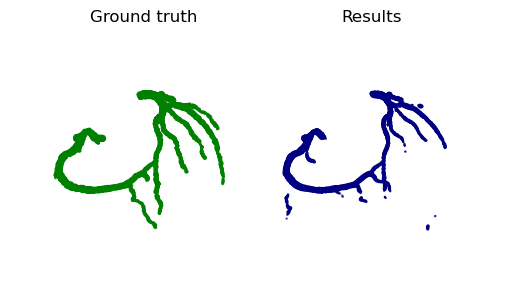

Ground truth number of points:  26058
Output number of points:  16044
Dice score: 0.81024337
Hausdorff:  17.50138282775879


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


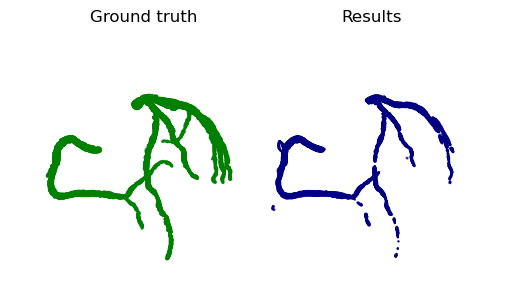

Ground truth number of points:  33561
Output number of points:  16251
Dice score: 0.7968935
Hausdorff:  25.766225814819336


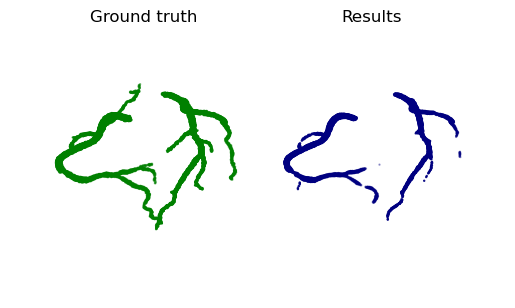

Ground truth number of points:  17737
Output number of points:  10079
Dice score: 0.84657806
Hausdorff:  21.428930282592773


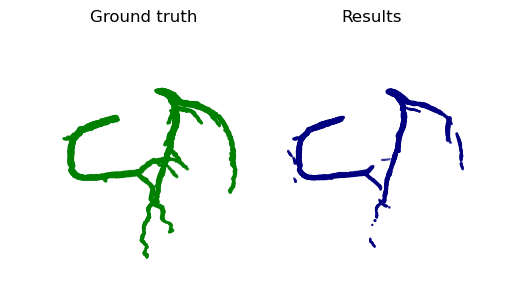

Ground truth number of points:  21873
Output number of points:  11570
Dice score: 0.8104283
Hausdorff:  15.524174690246582


In [17]:
for sample in test_loader:
    visual_evaluation(sample, model.to('cuda:1'))

In [ ]:
for sample in secrettest_loader:
    visual_evaluationtest(sample, model.to('cuda:1'))

In [8]:
# Check GPU memory
!nvidia-smi

Thu Apr  3 22:35:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A16                     Off |   00000000:1B:00.0 Off |                    0 |
|  0%   45C    P0             41W /   62W |   14953MiB /  15356MiB |     55%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Check if voxel size and dimensions match
data = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)('ASOCA_secret/1.img.nii.gz')
print(data.pixdim)
print(data.shape)

data = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)('Output/1.mask.nii.gz')
print(data.pixdim)
print(data.shape)
fig = monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(data), every_n=10)